# Calcul des coefficients des 5 fonctions de transferts

Executer tous les codes de la partie Initialisation. 
\
Les parties "Sratégie k" sont indépendantes et peuvent être éxecutées ou non.

## Initialisation

In [436]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import signal as sg
from scipy import integrate
from scipy.interpolate import interpn,interp1d,RegularGridInterpolator, Akima1DInterpolator

import time
from tqdm import notebook
import importlib

import torch
from torch.utils.data import TensorDataset, DataLoader

import tarfile

%matplotlib inline

import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


J'ai un modifié pred pour qu'elle puisse fonctionner pour n'importe quel degré de fonction de transfert

In [83]:
from scipy.optimize import minimize
import scipy.signal as sig
from scipy.optimize import least_squares

#b = [2,1]       # numerateur
#a = [1,0.5,1]     # denominateur

#H_1 = sig.lti(b,a)

def pred(x, t_e, entree):
    b = x[:int(len(x)/2)]
    a = x[int(len(x)/2):]
    H_1 = sig.lti(b,a)
    [t_s, sortie, xout] = H_1.output(entree,t_e)
    return sortie

def err(x, t, entree, y):
    return (pred(x, t, entree) - y)**2

def err_mean(x, t, entree, y):
    return np.mean(err(x,t,entree,y))

def err_multi(x, times, entrees, outputs):
    error = 0
    for k in range(len(entrees)) :
        error += np.mean(err(x,times[k],entrees[k],outputs[k]))
    return error 

def err_multi_ponde(x,times, entrees, outputs, poids):
    error = 0
    for k in range(len(entrees)) :
        error += poids[k]*np.mean(err(x,times[k],entrees[k],outputs[k]))
    return error 
    

def RMSE(real,prediction):
    rmse = 0
    for k in range(len(real)):
        rmse += (real[k]-prediction[k])**2
    return rmse/len(real)

In [437]:
rep_data = "./data/DataSet_phase1/"
names = ["input"+str(k) for k in range(0,7)]  

d = {}
for name in names:
    d[name] = pd.read_csv(rep_data + name + '.csv',sep=',',index_col=False)
    
columns_titles = ['Time','Input','Output1','Output2','Output3','Output4','Output5']

for name in names:
    d[name] = d[name].reindex(columns = columns_titles)

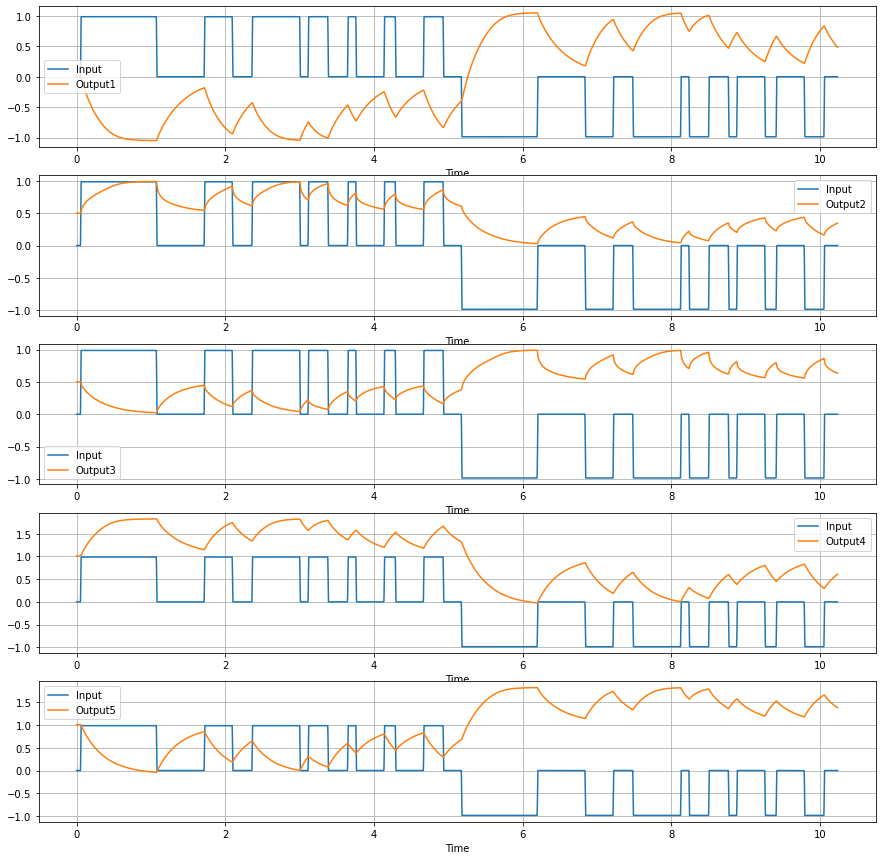

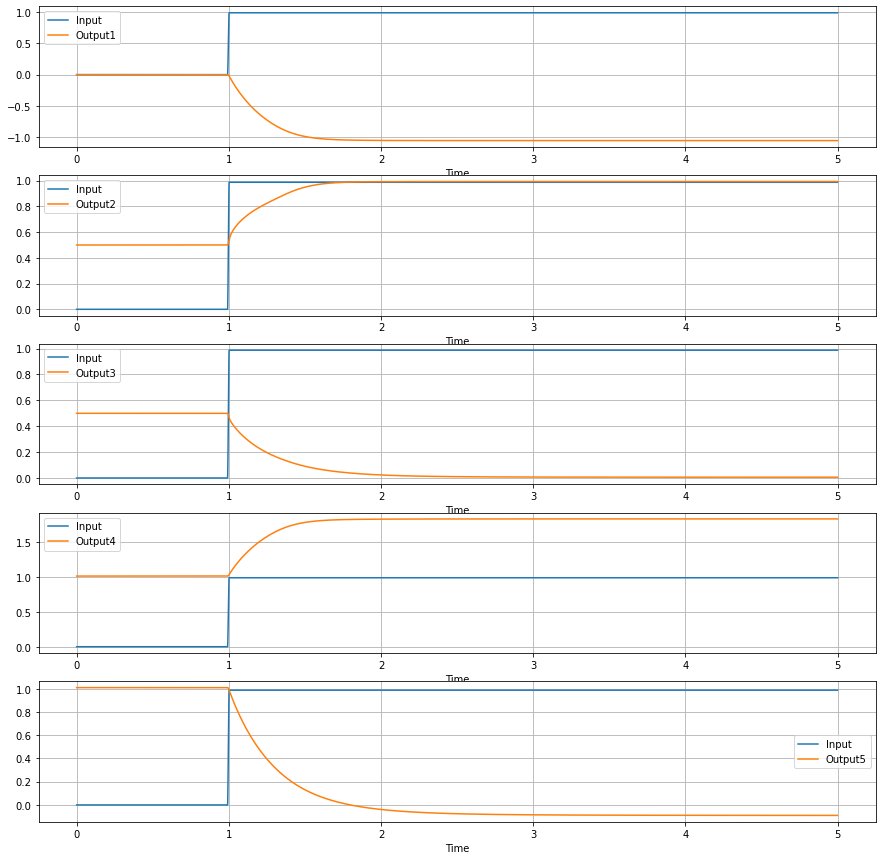

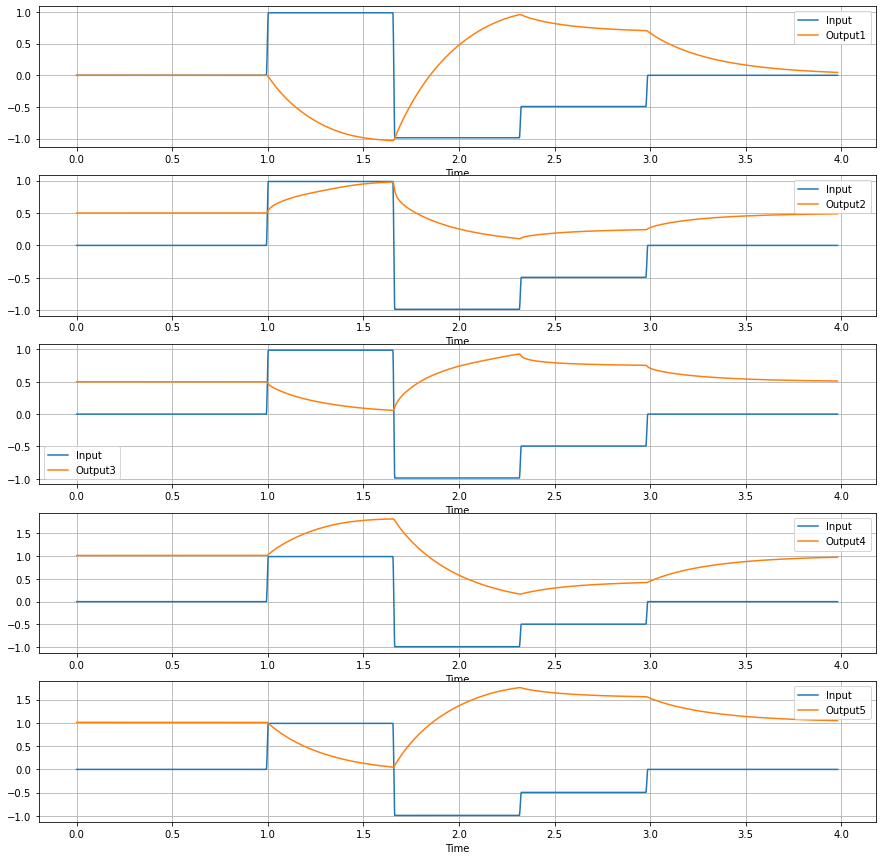

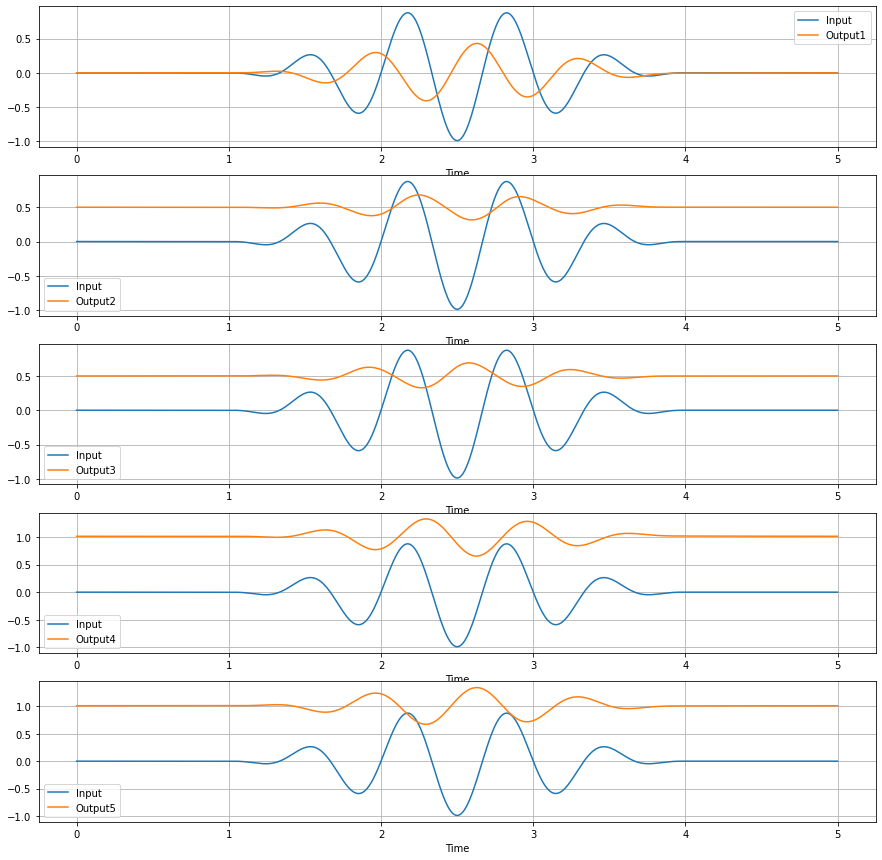

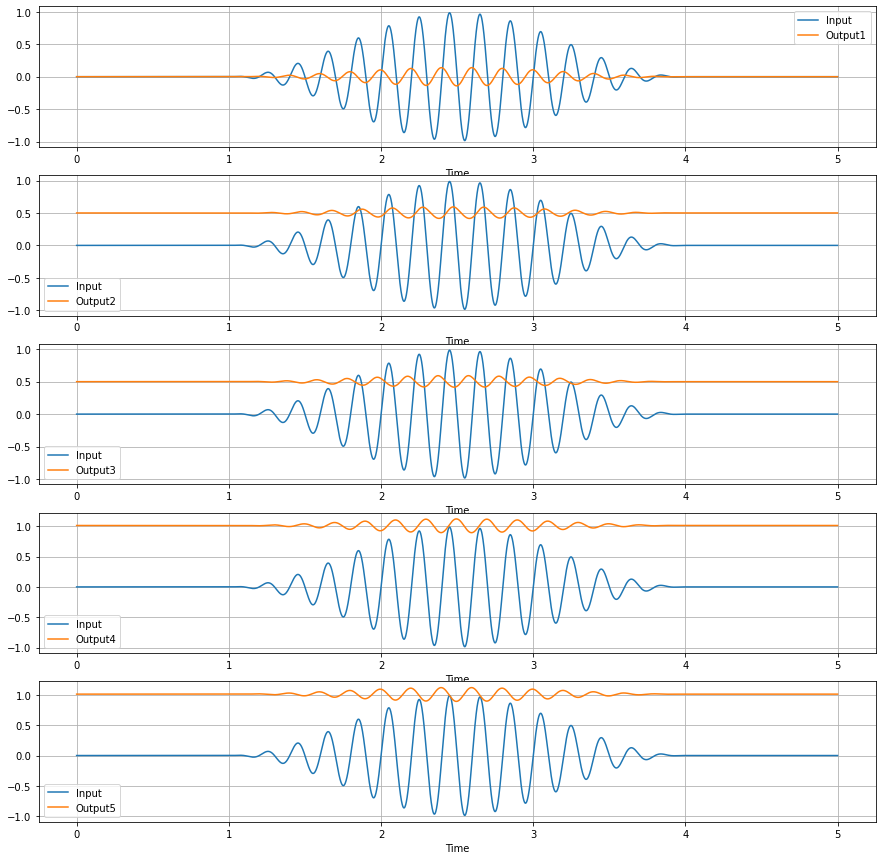

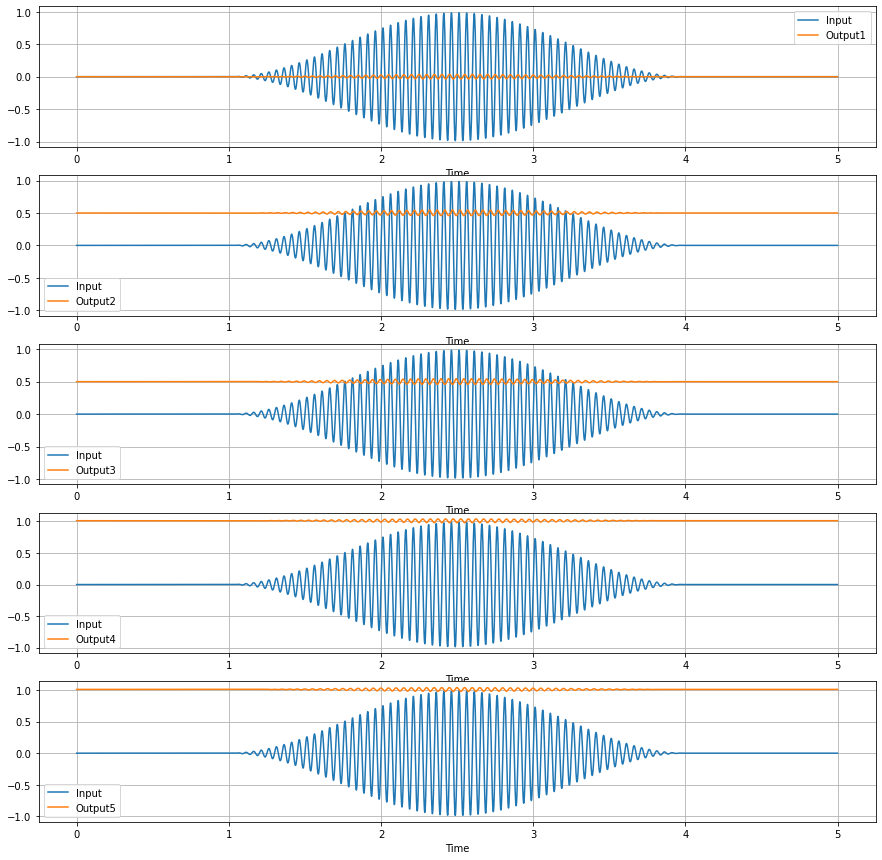

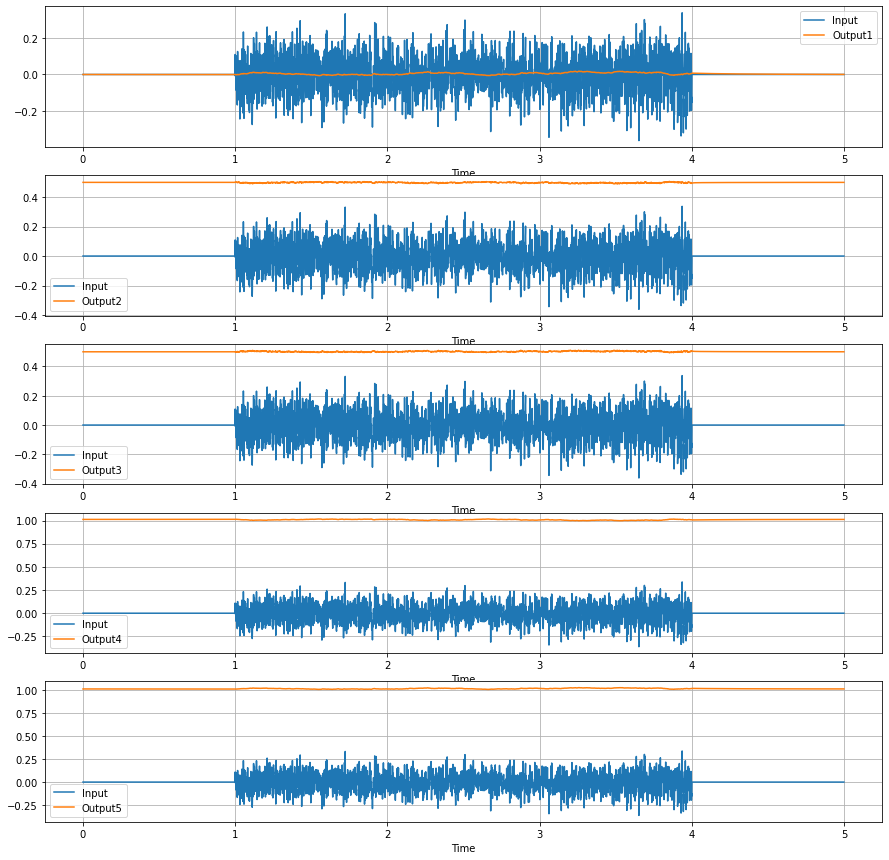

In [438]:
##Tracé des inputs et des outputs

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        d[name].plot(ax=ax[k],x='Time',y=[1,k+2],grid='on')

Il est nécessaire de standardiser les Outputs pour utiliser les modules scipy LTI, on supprime l'offset et on normalise à 1 les Output

In [39]:
##Calcul des shrink (positif ou négatif) et des offset de chaque output

Output_names = ['Output1','Output2','Output3','Output4','Output5']
Output_correction = {'Output1':[0,0],'Output2':[0,0],'Output3':[0,0],'Output4':[0,0],'Output5':[0,0]}
for name in Output_names:
    offset = d['input0'][name][1]
    Output_correction[name][0] = offset
    
    shrink = (d['input1'][name][5000]-offset)/d['input1']['Input'][5000]
    Output_correction[name][1] = shrink

In [40]:
###Traitement des output
   
d_corrige = copy.deepcopy(d)
    
for key in d_corrige.keys():
    for name in Output_names:
        d_corrige[key][name] = d[key][name] - Output_correction[name][0] 
        d_corrige[key][name] = 1/Output_correction[name][1]*d_corrige[key][name]

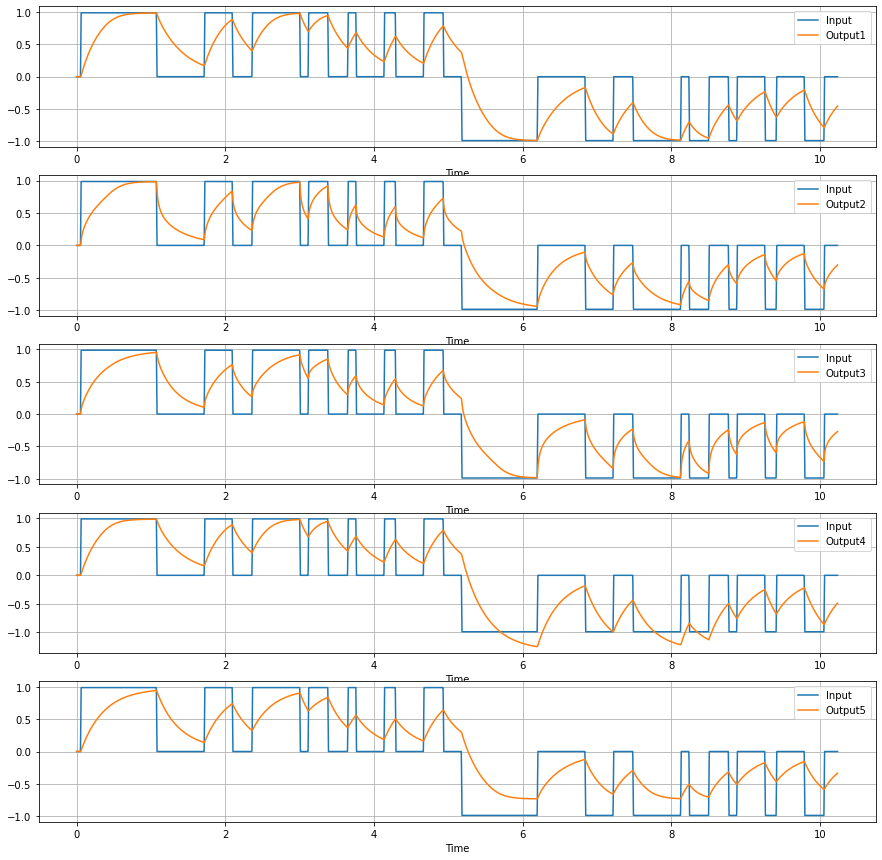

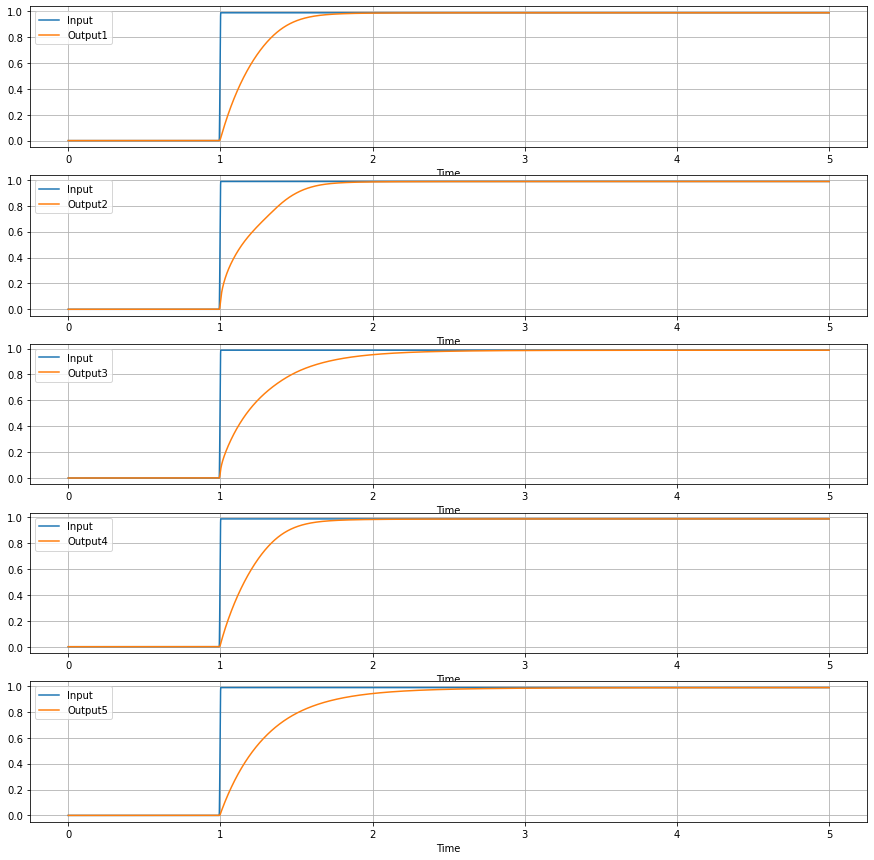

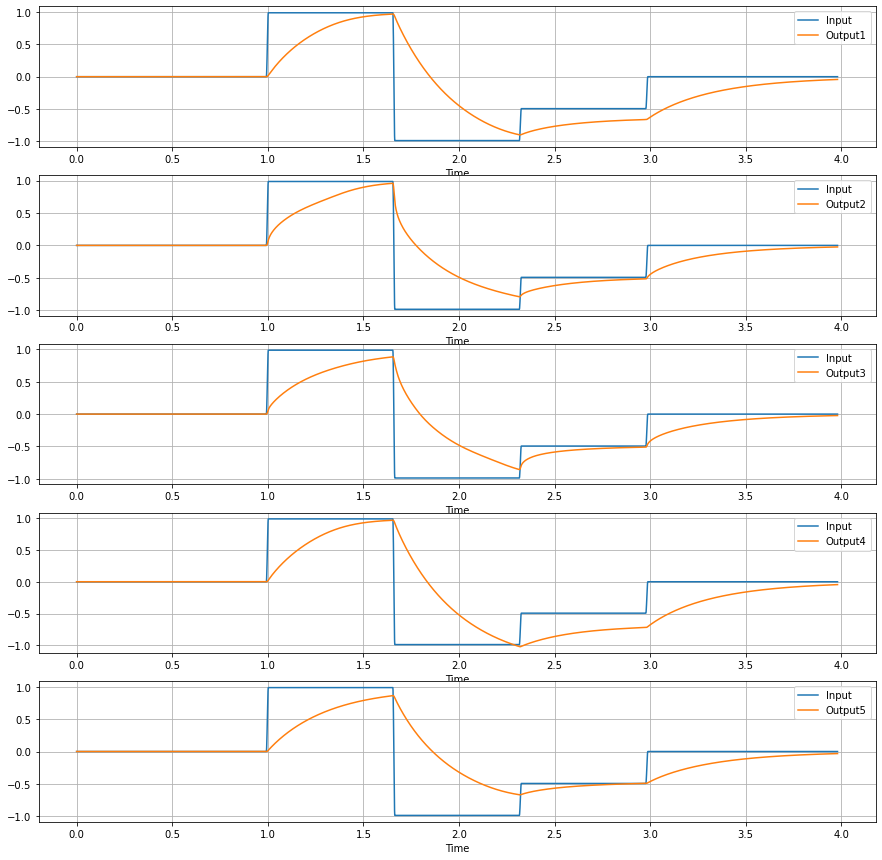

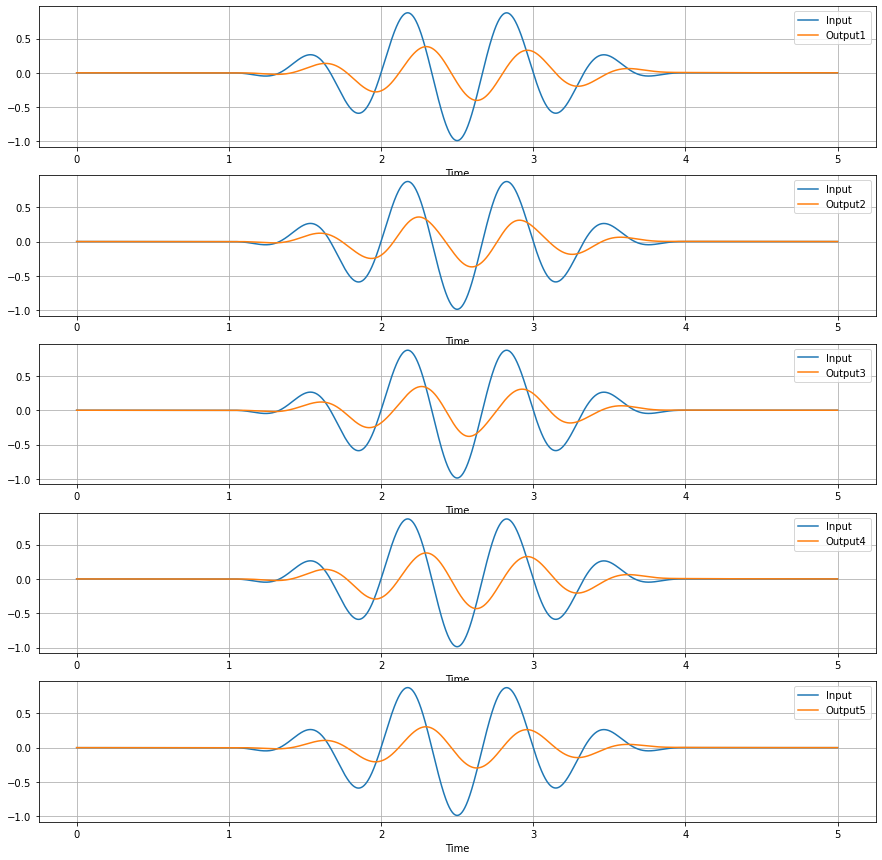

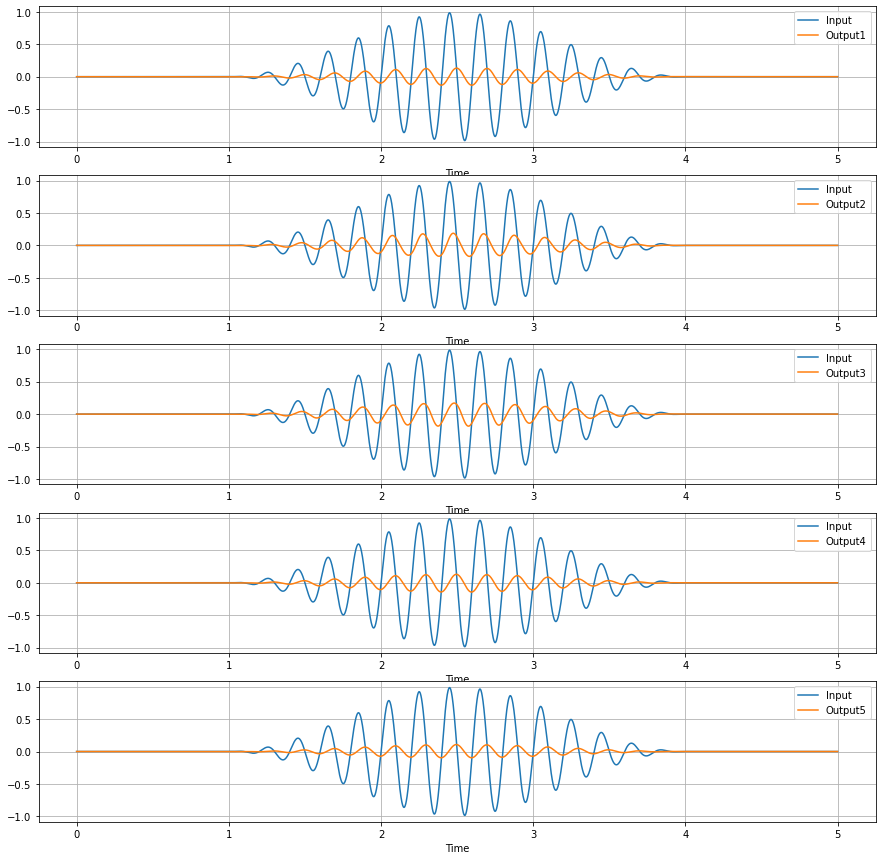

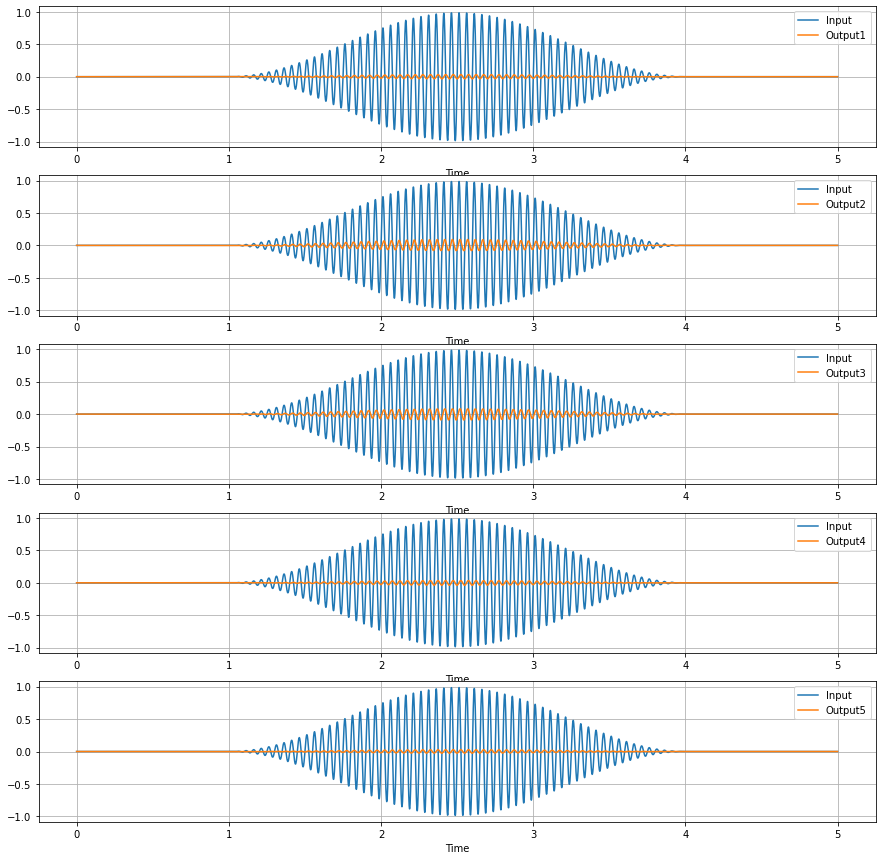

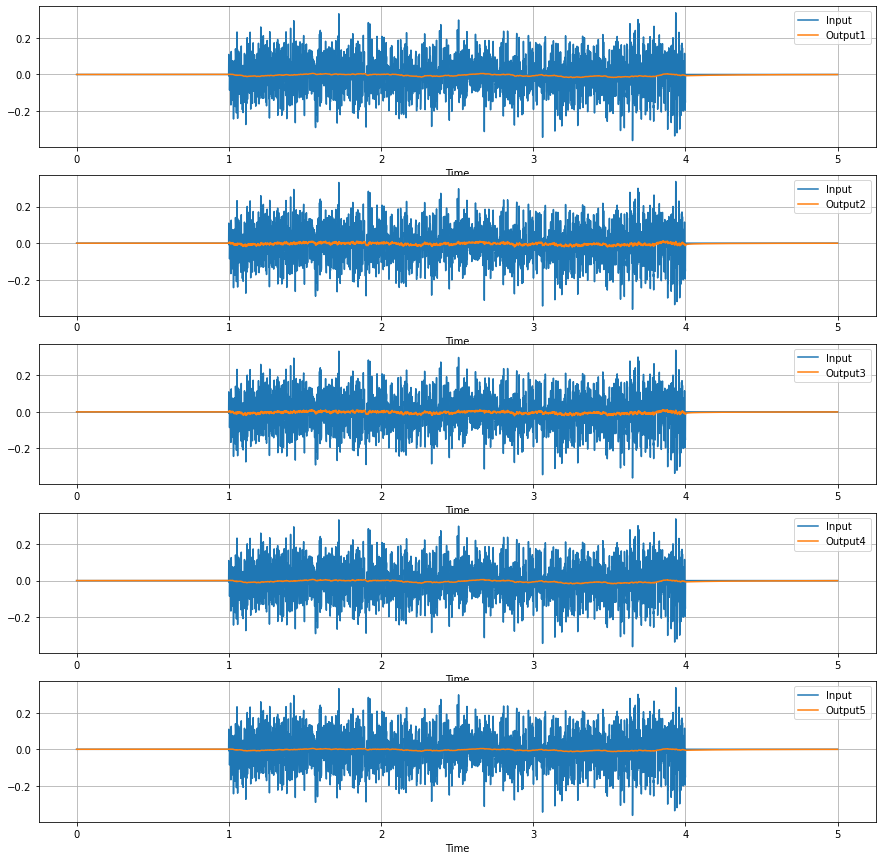

In [209]:
##Tracé des inputs et des Outputs corrigés

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    _,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        d_corrige[name].plot(ax=ax[k],x='Time',y=[1,k+2],grid='on')

## Stratégie 3 : Moyenne pondérée selon la similitude entre les inputs

Ici on aura des coefficients pour chacun des inputs pour une fonction de transfert donnée (un indice d'output), donc $N_{outputs}\times N_{inputs}$.
\
On définit des paramètres pour classifier les inputs

In [341]:
def calcul_lipschitz(Time,Input):
    max_L = 1
    L = 1
    Time_step = Time[1]-Time[0]
    for k in range(len(Time)-1):
        L = np.abs(Input[k+1]-Input[k])/np.abs(Time_step)
        if L > max_L :
            max_L = L    
    return max_L    



def calcul_changements_signe(Time,Input):
    compteur = 0
    
    for k in range(2,len(Time)):
        if (Input[k]*Input[k-1]<0):
            compteur += 1
            
    return compteur   

In [439]:
def calcul_params_inputs(dic):
    params_inputs = {}
    moyenne_lip = 0
    moyenne_chgmt_signe = 0
    for inp in dic.keys():
        Time = dic[inp]['Time']
        Input = dic[inp]['Input']
        params_inputs[inp] = [] ##[lip,chgmt_signe]
        lip = calcul_lipschitz(Time,Input)
        chgmt_signe = calcul_changements_signe(Time,Input)
        params_inputs[inp].append(lip)
        params_inputs[inp].append(chgmt_signe)
        moyenne_lip += lip/len(dic)
        moyenne_chgmt_signe += chgmt_signe/len(dic)

    ##normalisation des params
    for inp in dic.keys():
        params_inputs[inp][0] = params_inputs[inp][0]/moyenne_lip
        params_inputs[inp][1] = params_inputs[inp][1]/moyenne_chgmt_signe
        
    return params_inputs

In [440]:
##Calcul des paramètres des inputs

inputs = ['input0','input1','input2','input3','input4','input5','input6']
dic = {}
for key in inputs:
    dic[key] = d[key]
params_inputs = calcul_params_inputs(dic)
params_inputs

{'input0': [0.8451886632657197, 0.0],
 'input1': [0.8522461515966162, 0.0],
 'input2': [1.7128667866329361, 0.005083514887436457],
 'input3': [0.05288301884027476, 0.040668119099491654],
 'input4': [0.1811852659053571, 0.14742193173565724],
 'input5': [0.7229540423917611, 0.5998547567175019],
 'input6': [2.6326760713673347, 6.206971677559913]}

In [441]:
from numpy import linalg as la
##grande similitude : signaux proches

def similitude_generale(poids,param1,param2):
    param_1 = np.array(param1)
    param_2 = np.array(param2)
    
    params_dif = param_1-param_2
    params_dif_norme = np.array([np.abs(param) for param in params_dif])
    norme = np.dot(poids,params_dif_norme)
    
    return 1/max([1e-15,norme])

In [84]:
##Coefficients pour chacun des inputs

inputs = d.keys()

params_output_3 = {}
for name in Output_names : 
    params_output_3[name] = {}
    
degre = 3
N_total = len(Output_names)*len(inputs)
Compteur = 0

for name in Output_names:
    for key in inputs :
        time = d[key]['Time']
        entree = d[key]['Input']
        output = d_corrige[key][name]

        x0 = np.ones(2*degre)
        x = np.arange(1,2*degre+1)

        res = least_squares(err, x0, bounds=(-3, 3), args=(time,entree,output), verbose=1, ftol=1e-15, gtol=1e-15, xtol = 1e-15, max_nfev = 80)
        
        ##res = minimize(err_mean, x0, args=(time,entree,output), method = "BFGS")
        x = res.x

        Compteur += 1
        print("Avancement : " + str(round(Compteur/N_total*100)) +"%")

        params_output_3[name][key] = x

    params_output_3[name] = pd.DataFrame(params_output_3[name])

Avancement : 3%
Avancement : 6%
Avancement : 9%
Avancement : 11%
Avancement : 14%
Avancement : 17%
Avancement : 20%
Avancement : 23%
Avancement : 26%
Avancement : 29%
Avancement : 31%
Avancement : 34%
Avancement : 37%
Avancement : 40%
Avancement : 43%
Avancement : 46%
Avancement : 49%
Avancement : 51%
Avancement : 54%
Avancement : 57%
Avancement : 60%
Avancement : 63%
Avancement : 66%
Avancement : 69%
Avancement : 71%
Avancement : 74%
Avancement : 77%
Avancement : 80%
Avancement : 83%
Avancement : 86%
Avancement : 89%
Avancement : 91%
Avancement : 94%
Avancement : 97%
Avancement : 100%


In [89]:
params_output_3

{'Output1':      input0    input1    input2    input3    input4    input5    input6
 0  0.002208 -0.016429  0.030844  0.003406  0.006492  0.000363  0.008465
 1  1.075854  2.033193  2.033015  2.016113  2.478012  2.464248  1.000763
 2  1.948026  0.703947  0.953612  0.765538  1.000974  1.000063  1.000761
 3  0.261240  0.418675  0.554847  0.502409  0.591210  0.590554  1.945643
 4  1.549586  2.155125  1.898356  1.809609  0.975480  0.998581  0.999322
 5  1.611752  0.711775  0.769150  0.977331  1.000424  1.000027  0.999261,
 'Output2':      input0    input1    input2    input3    input4    input5    input6
 0  0.052375  0.050733  0.088134  0.063309  0.066098  0.020065  0.059555
 1  1.614640  1.942856  1.805869  1.839462  2.579368  2.873674  1.000350
 2  1.144831  0.725256  0.974786  0.524597  1.000881  1.000061  1.000227
 3  0.404708  0.475229  0.482873  0.506795  0.583398  0.349033  1.898399
 4  1.919454  2.066032  2.044498  2.120932  0.814099  0.890237  0.999716
 5  1.136839  0.734959  0.79

Check des coefficients et suppression des valeurs absurdes/trop mauvaises

In [146]:
###Calcul des outputs approximés

Sorties_v3_verif = copy.deepcopy(d)

    
N_total = len(Output_names)*len(inputs)
Compteur = 0

for key in inputs:
    for name in Output_names :
        
        Time = d[key]['Time']
        Input = d[key]['Input']                       
        x = params_output_3[name][key]
        sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0] 
        Sorties_v3_verif[key][name+"_approx"] = sortie
        Sorties_v3_verif[key][name+"_approx"] = pd.DataFrame(Sorties_v3_verif[key][name+"_approx"]) 
        
        Compteur += 1
        print("Avancement : " + str(round(Compteur/N_total*100)) +"%")    
    

Avancement : 3%
Avancement : 6%
Avancement : 9%
Avancement : 11%
Avancement : 14%
Avancement : 17%
Avancement : 20%
Avancement : 23%
Avancement : 26%
Avancement : 29%
Avancement : 31%
Avancement : 34%
Avancement : 37%
Avancement : 40%
Avancement : 43%
Avancement : 46%
Avancement : 49%
Avancement : 51%
Avancement : 54%
Avancement : 57%
Avancement : 60%
Avancement : 63%
Avancement : 66%
Avancement : 69%
Avancement : 71%
Avancement : 74%
Avancement : 77%
Avancement : 80%
Avancement : 83%
Avancement : 86%
Avancement : 89%
Avancement : 91%
Avancement : 94%
Avancement : 97%
Avancement : 100%


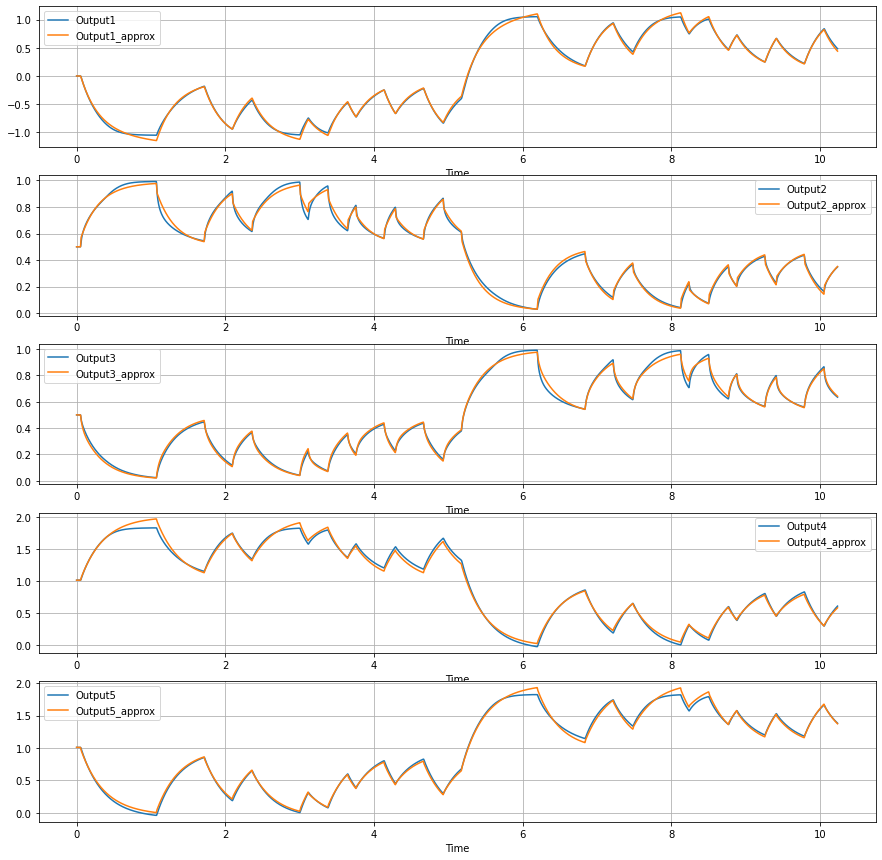

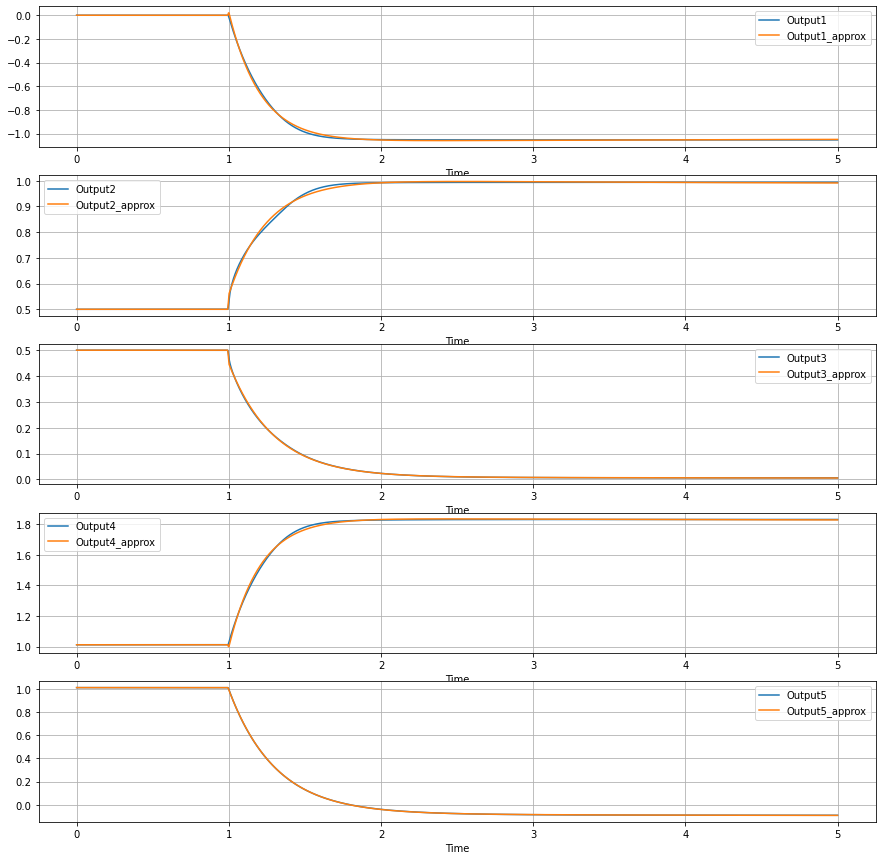

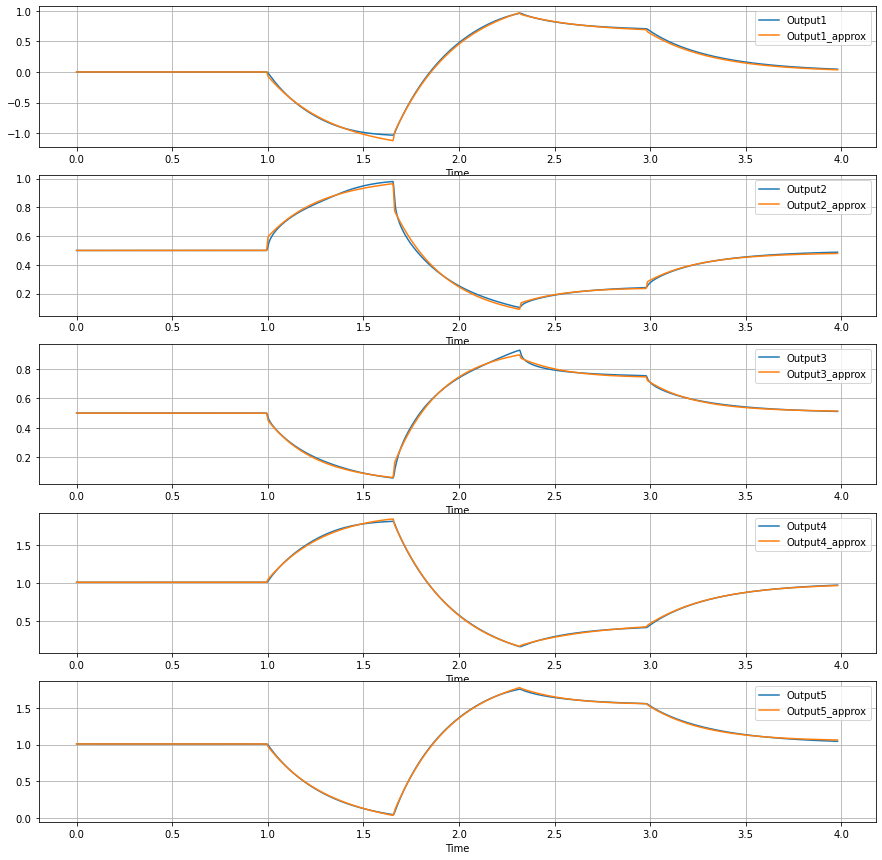

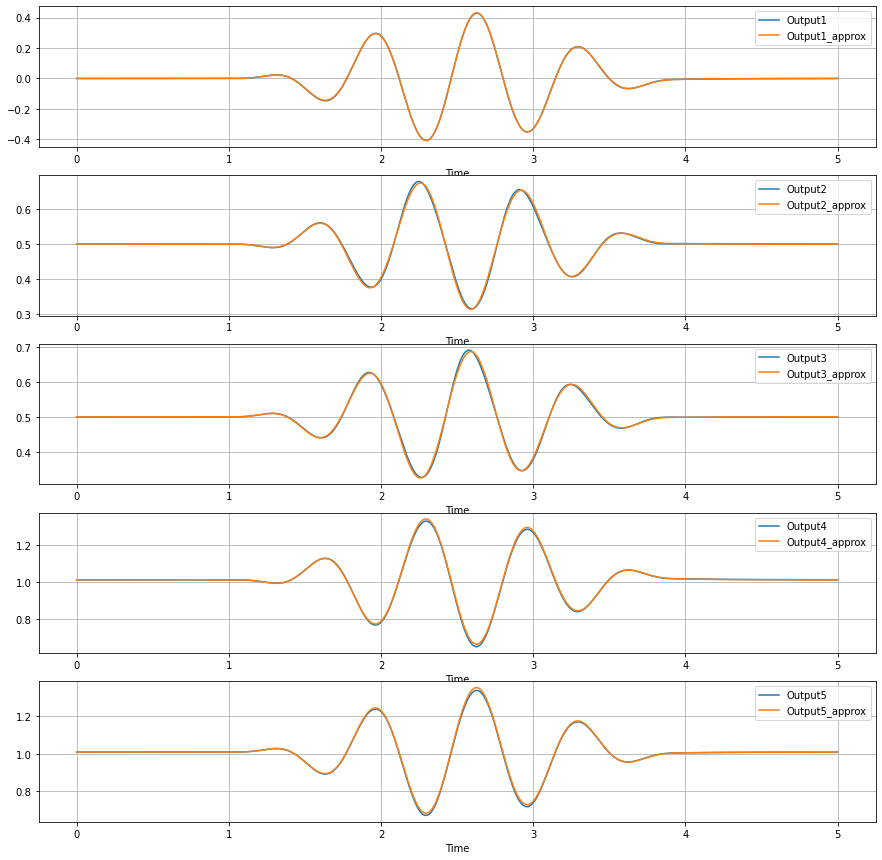

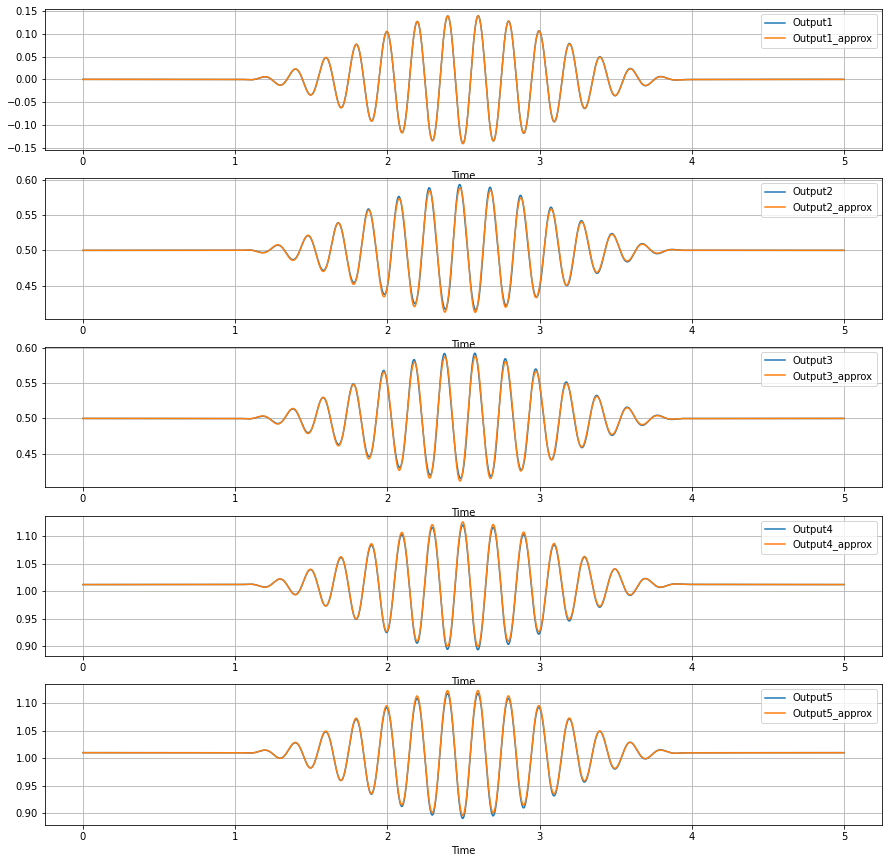

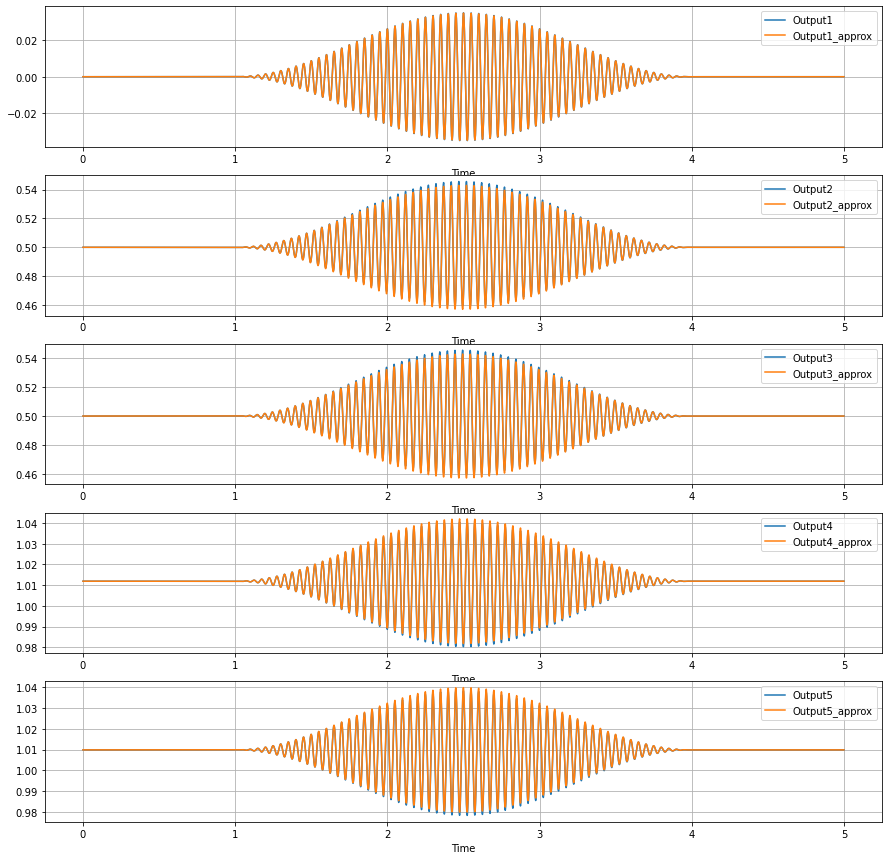

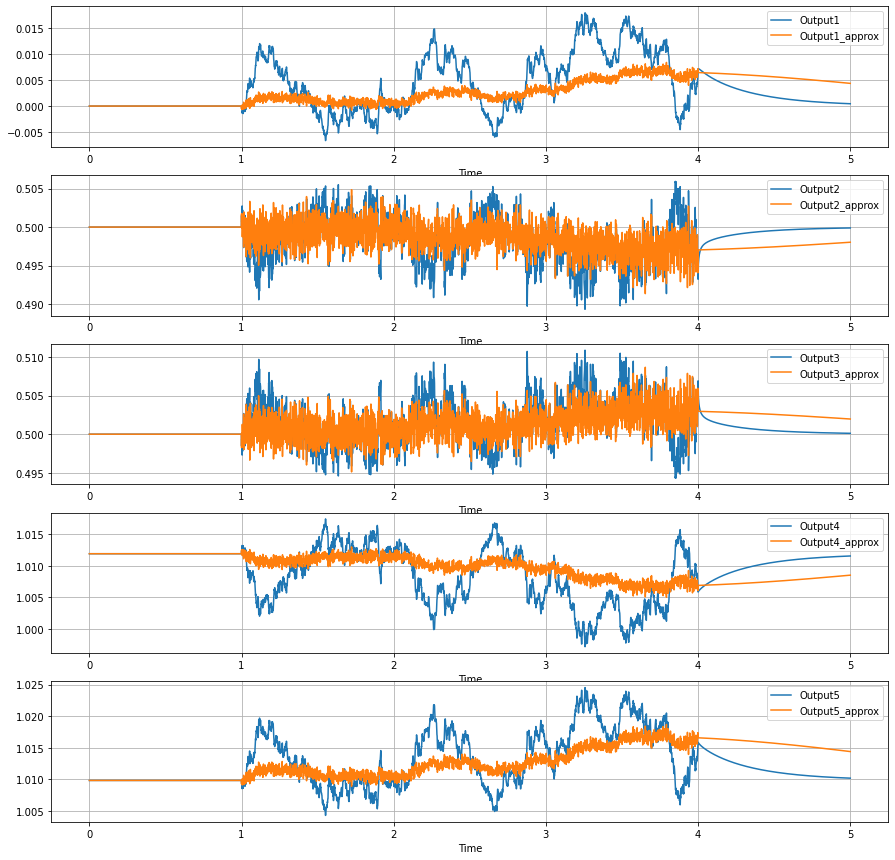

In [105]:
##Tracé des outputs et des outputs approximés

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in inputs:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v3_verif[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

On évitera de train sur le bruit dans la suite

In [420]:
###Calcul des output approximés en fonction des autres outputs avec similitude et poids initial 


inputs = ['input0','input1','input2','input3','input4','input5','input6']
Sorties_v3 = copy.deepcopy(d)
poids = np.array([1,1])

for key in inputs:
    for name in Output_names:
        Sorties_v3[key][name+"_approx"] = np.zeros(len(d[key]['Time']))
    
N_total = len(Output_names)*len(inputs)
Compteur = 0

for key in inputs:
    inputs_train = []
    for inp in inputs:
        if (inp != key) and (inp != "input6")  : inputs_train.append(inp)

    for name in Output_names :
        similitudes_dic = {}
        for key_train in inputs_train:
            time1 = d[key]['Time']
            time2 = d[key_train]['Time']
            time = 0
            if len(time1) > len(time2) : time = time2
            else : time = time1
            similitudes_dic[key_train] = similitude_generale(poids,params_inputs[key],params_inputs[key_train])**2 ##On choisit la mesure de similitude ici
        somme = sum(list(similitudes_dic.values()))
        
        for key_train in inputs_train:
            Time = d[key]['Time']
            Input = d[key]['Input']                       
            x = params_output_3[name][key_train]
            sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0] 
            Sorties_v3[key][name+"_approx"] += sortie*(similitudes_dic[key_train]/somme)
        Sorties_v3[key][name+"_approx"] = pd.DataFrame(Sorties_v3[key][name+"_approx"]) 
        
        Compteur += 1
        print("Avancement : " + str(round(Compteur/N_total*100)) +"%")        

{'input1': 50192597.4884077, 'input2': 1986.403306841502, 'input3': 313.1009172531522, 'input4': 38.72196946812947, 'input5': 2.7566083546948157}
Avancement : 3%
{'input1': 50192597.4884077, 'input2': 1986.403306841502, 'input3': 313.1009172531522, 'input4': 38.72196946812947, 'input5': 2.7566083546948157}
Avancement : 6%
{'input1': 50192597.4884077, 'input2': 1986.403306841502, 'input3': 313.1009172531522, 'input4': 38.72196946812947, 'input5': 2.7566083546948157}
Avancement : 9%
{'input1': 50192597.4884077, 'input2': 1986.403306841502, 'input3': 313.1009172531522, 'input4': 38.72196946812947, 'input5': 2.7566083546948157}
Avancement : 11%
{'input1': 50192597.4884077, 'input2': 1986.403306841502, 'input3': 313.1009172531522, 'input4': 38.72196946812947, 'input5': 2.7566083546948157}
Avancement : 14%
{'input0': 50192597.4884077, 'input2': 2011.6337324371143, 'input3': 311.542757446255, 'input4': 38.65403746389812, 'input5': 2.7553167782477335}
Avancement : 17%
{'input0': 50192597.48840

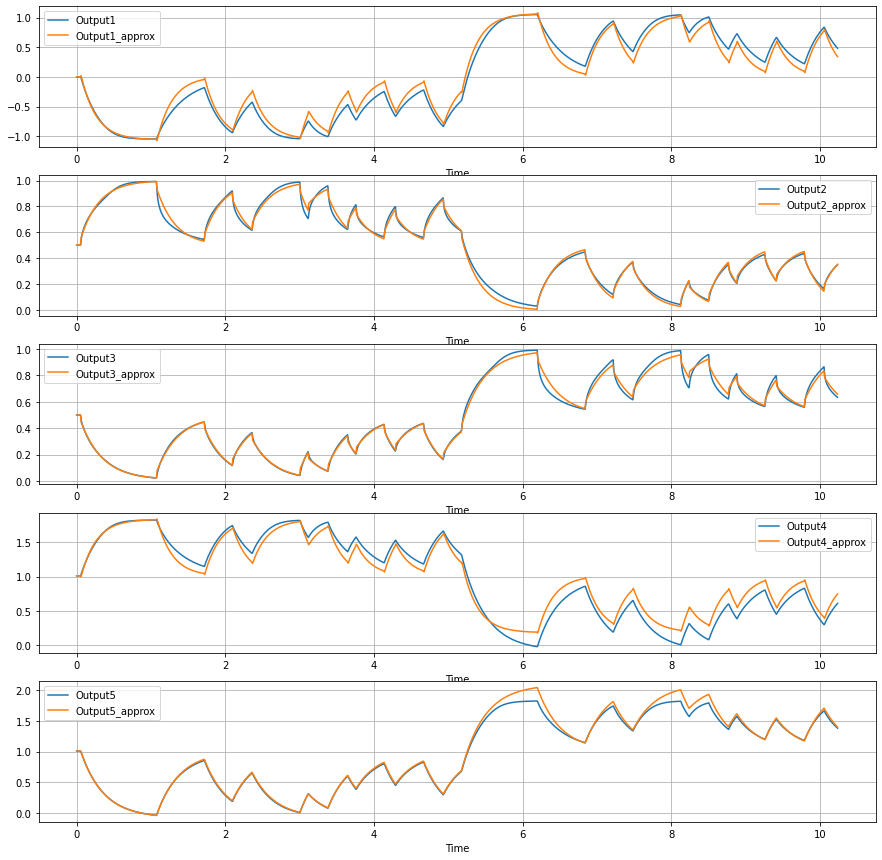

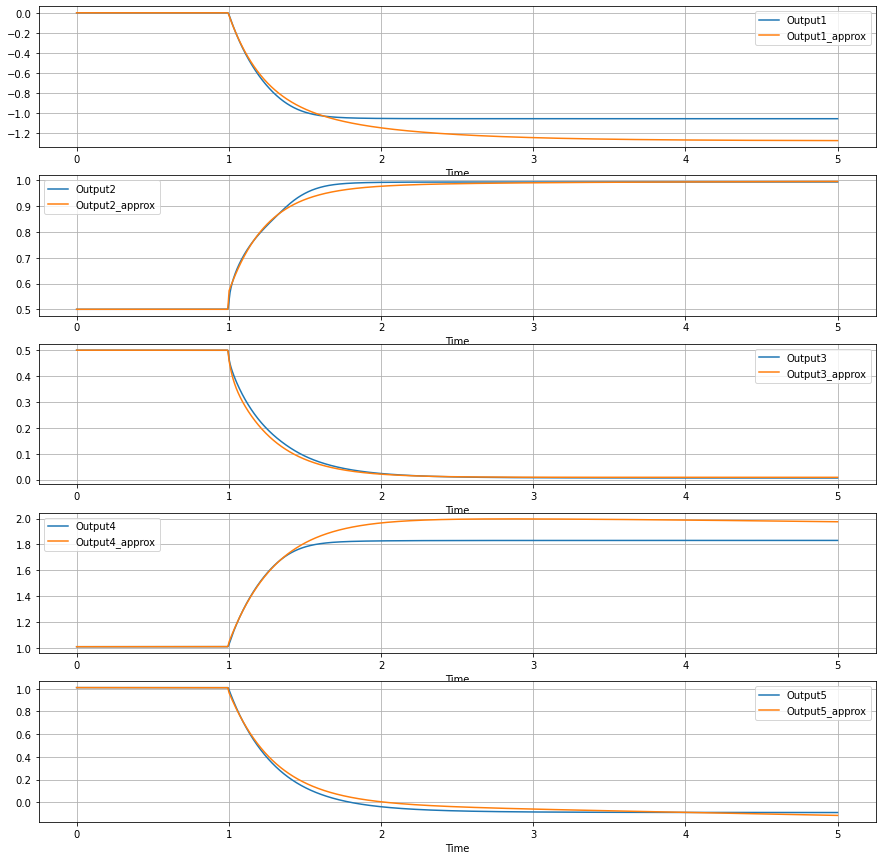

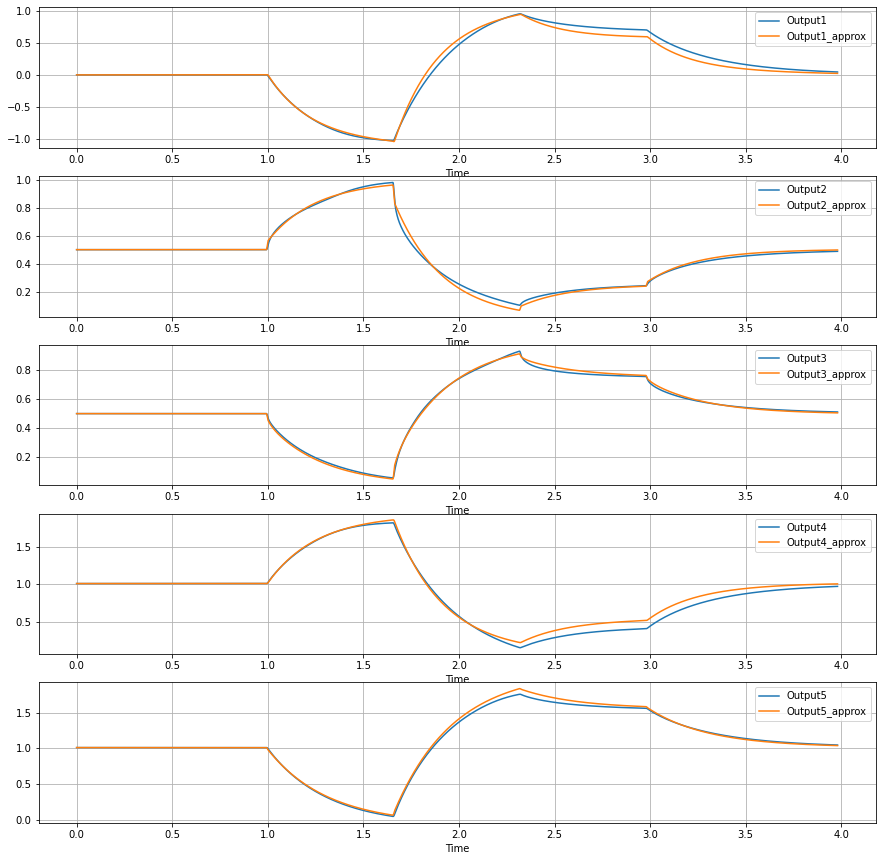

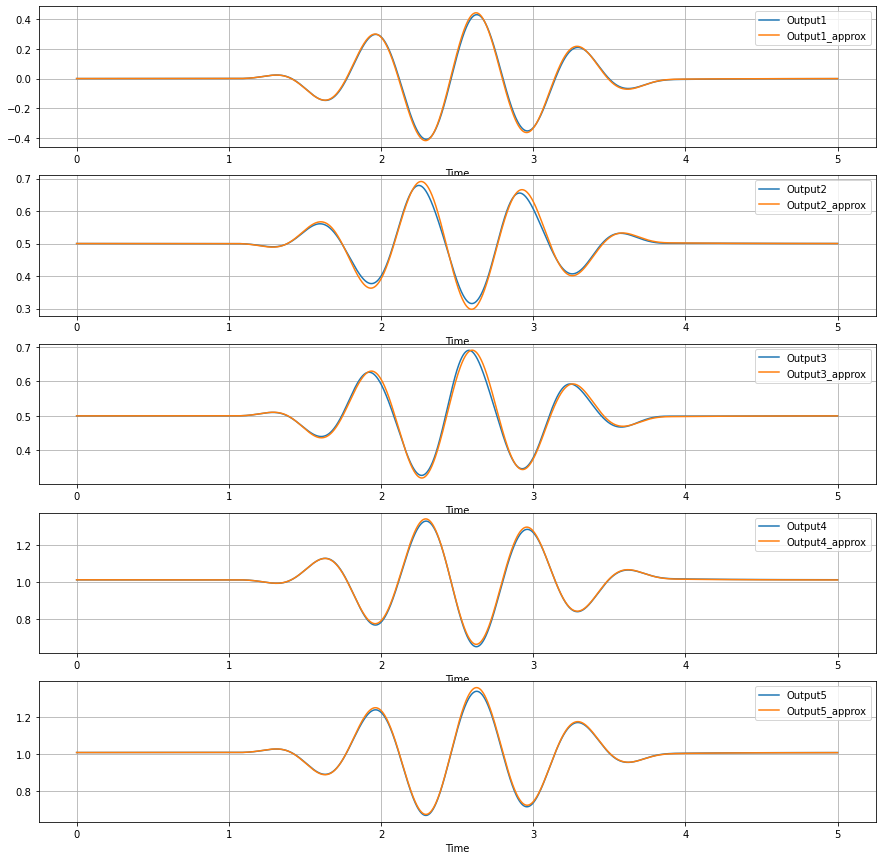

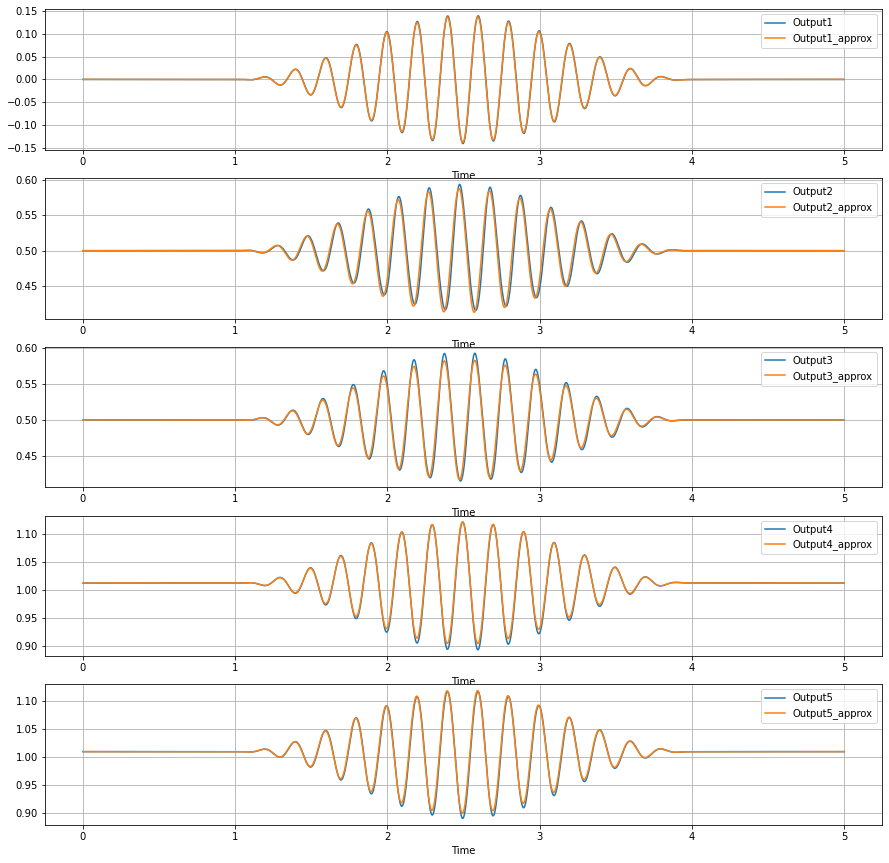

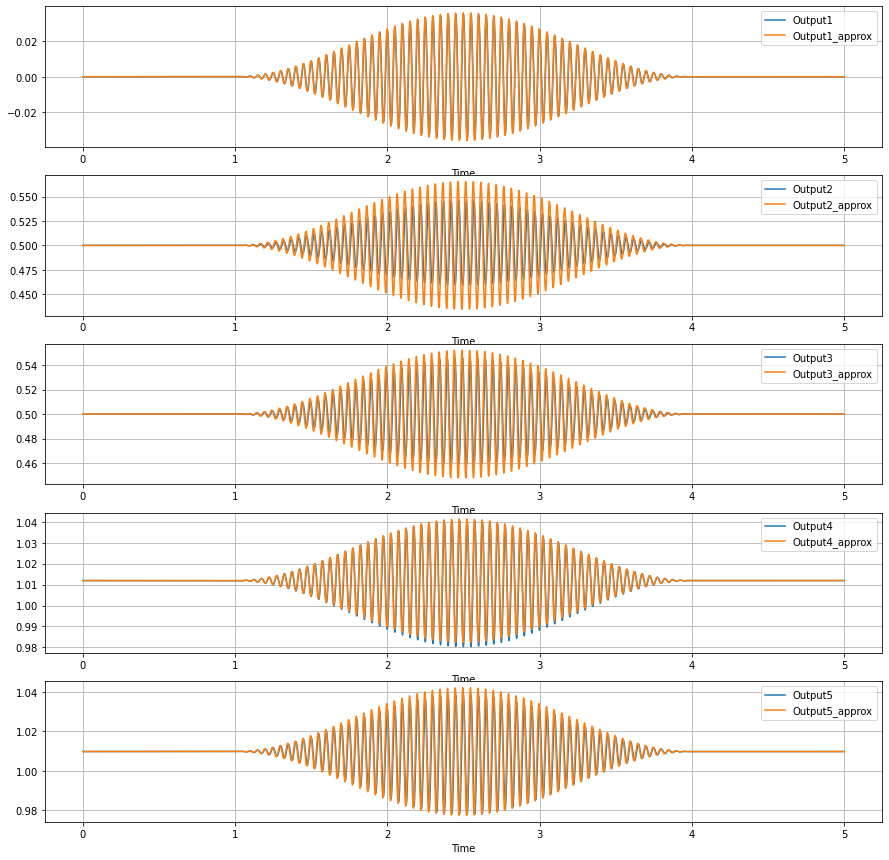

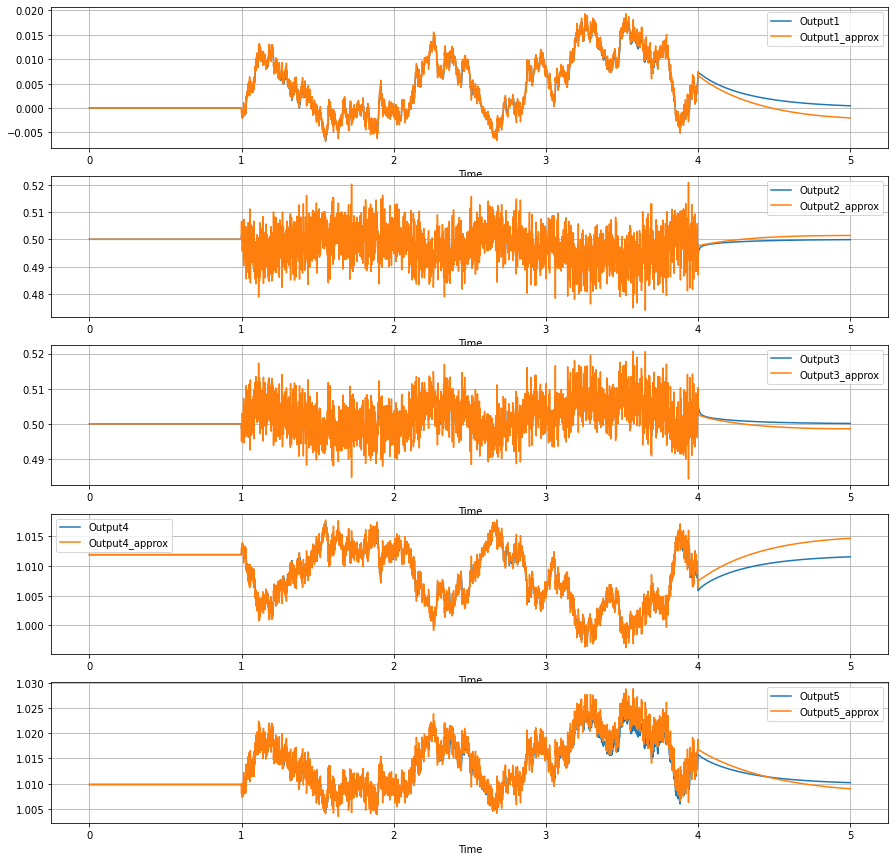

In [421]:
##Tracé des outputs et des outputs approximés sur l'échantillon de test

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in inputs:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v3[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

In [422]:
###RMSE pour les signaux de test

N_input   = 1
N_outputs = 5
N_signals = len(names)
mean_rmse = 0


for name in inputs:
    for k in range(N_outputs):
        rmse = RMSE(Sorties_v3[name][Output_names[k]],Sorties_v3[name][Output_names[k]+"_approx"])
        mean_rmse += rmse*(name in inputs)/(5*len(inputs))
        print("RMSE pour " + str(name) +" et " + Output_names[k] + " : " + str(rmse))
        print("-----------------")

print("RMSE moyenne sur echantillon test : " + str(mean_rmse) )

RMSE pour input0 et Output1 : 0.014285807570166694
-----------------
RMSE pour input0 et Output2 : 0.0005487837930484154
-----------------
RMSE pour input0 et Output3 : 0.0006166240906010605
-----------------
RMSE pour input0 et Output4 : 0.0159818877385415
-----------------
RMSE pour input0 et Output5 : 0.003993427548766431
-----------------
RMSE pour input1 et Output1 : 0.022574417851723247
-----------------
RMSE pour input1 et Output2 : 7.985659617187191e-05
-----------------
RMSE pour input1 et Output3 : 5.028503094925659e-05
-----------------
RMSE pour input1 et Output4 : 0.0159216719716229
-----------------
RMSE pour input1 et Output5 : 0.0006080018101863853
-----------------
RMSE pour input2 et Output1 : 0.003731542393195262
-----------------
RMSE pour input2 et Output2 : 0.0003099037903803763
-----------------
RMSE pour input2 et Output3 : 0.00010460779459305846
-----------------
RMSE pour input2 et Output4 : 0.003211662696506608
-----------------
RMSE pour input2 et Output5 : 

### Recherche des poids optimaux dans le calcul de similitude


Fonction qui calcule l erreur moyenne globale de la methode similitude

In [427]:
def erreur_moyenne_simi(poids,inputs,params_output,params_inputs,d):

    for key in inputs:
        for name in Output_names:
            Sorties_v3[key][name+"_approx"] = np.zeros(len(d[key]['Time']))

    N_total = len(Output_names)*len(inputs)
    Compteur = 0

    for key in inputs:
        inputs_train = []
        for inp in inputs:
            if (inp != key) and (inp != "input6")  : inputs_train.append(inp)

        for name in Output_names :
            similitudes_dic = {}
            for key_train in inputs_train:
                time1 = d[key]['Time']
                time2 = d[key_train]['Time']
                time = 0
                if len(time1) > len(time2) : time = time2
                else : time = time1
                similitudes_dic[key_train] = similitude_generale(poids,params_inputs[key],params_inputs[key_train])**2 ##On choisit la mesure de similitude ici
            somme = sum(list(similitudes_dic.values()))

            for key_train in inputs_train:
                Time = d[key]['Time']
                Input = d[key]['Input']                       
                x = params_output[name][key_train]
                sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0] 
                Sorties_v3[key][name+"_approx"] += sortie*(similitudes_dic[key_train]/somme)
            Sorties_v3[key][name+"_approx"] = pd.DataFrame(Sorties_v3[key][name+"_approx"]) 
            
    mean_rmse = 0
    N_outputs = 5

    for name in inputs:
        for k in range(N_outputs):
            rmse = RMSE(Sorties_v3[name][Output_names[k]],Sorties_v3[name][Output_names[k]+"_approx"])
            mean_rmse += rmse*(name in inputs)/(5*len(inputs))
    
    return mean_rmse

In [428]:
##recherche des poids optimaux dans la similitude

x0 = np.array([0.5,0.5])
x = np.arange(1,3)
res = least_squares(erreur_moyenne_simi, x0, args=(inputs,params_output_3,params_inputs,d), verbose=2, ftol=1e-15, gtol=1e-15, xtol = 1e-15, max_nfev = 12)
poids_opti = res.x
print(poids_opti)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.0427e-06                                    4.85e-06    
       1              2         2.9117e-06      2.13e-06       7.07e-01       2.25e-06    
       2              4         2.8436e-06      6.82e-08       1.77e-01       1.93e-06    
       3              5         2.7710e-06      7.26e-08       4.42e-02       1.26e-06    
       4              7         2.7484e-06      2.26e-08       2.21e-02       7.50e-07    
       5              8         2.7466e-06      1.77e-09       4.42e-02       8.16e-07    
       6              9         2.7403e-06      6.35e-09       1.10e-02       3.40e-07    
       7             10         2.7389e-06      1.41e-09       1.10e-02       7.58e-08    
       8             12         2.7388e-06      7.44e-11       2.76e-03       2.28e-08    
The maximum number of function evaluations is exceeded.
Function evaluations 12, initial c

In [435]:
poids_opti = [0.08671119,1.01408954]
erreur_moyenne_simi(poids_opti,inputs,params_output_3,params_inputs,d)

0.0023404262578827118

In [425]:
###Calcul des output approximés en fonction des autres outputs avec similitude
inputs = ['input0','input1','input2','input3','input4','input5','input6']
Sorties_v3 = copy.deepcopy(d)
poids = poids_opti

for key in inputs:
    for name in Output_names:
        Sorties_v3[key][name+"_approx"] = np.zeros(len(d[key]['Time']))
    
N_total = len(Output_names)*len(inputs)
Compteur = 0

for key in inputs:
    inputs_train = []
    for inp in inputs:
        if (inp != key) and (inp != "input6")  : inputs_train.append(inp)

    for name in Output_names :
        similitudes_dic = {}
        for key_train in inputs_train:
            time1 = d[key]['Time']
            time2 = d[key_train]['Time']
            time = 0
            if len(time1) > len(time2) : time = time2
            else : time = time1
            similitudes_dic[key_train] = similitude_generale(poids,params_inputs[key],params_inputs[key_train])**2 ##On choisit la mesure de similitude ici
        somme = sum(list(similitudes_dic.values()))
        
        for key_train in inputs_train:
            Time = d[key]['Time']
            Input = d[key]['Input']                       
            x = params_output_3[name][key_train]
            sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0] 
            Sorties_v3[key][name+"_approx"] += sortie*(similitudes_dic[key_train]/somme)
        Sorties_v3[key][name+"_approx"] = pd.DataFrame(Sorties_v3[key][name+"_approx"]) 
        
        Compteur += 1
        print("Avancement : " + str(round(Compteur/N_total*100)) +"%")        

Avancement : 3%
Avancement : 6%
Avancement : 9%
Avancement : 11%
Avancement : 14%
Avancement : 17%
Avancement : 20%
Avancement : 23%
Avancement : 26%
Avancement : 29%
Avancement : 31%
Avancement : 34%
Avancement : 37%
Avancement : 40%
Avancement : 43%
Avancement : 46%
Avancement : 49%
Avancement : 51%
Avancement : 54%
Avancement : 57%
Avancement : 60%
Avancement : 63%
Avancement : 66%
Avancement : 69%
Avancement : 71%
Avancement : 74%
Avancement : 77%
Avancement : 80%
Avancement : 83%
Avancement : 86%
Avancement : 89%
Avancement : 91%
Avancement : 94%
Avancement : 97%
Avancement : 100%


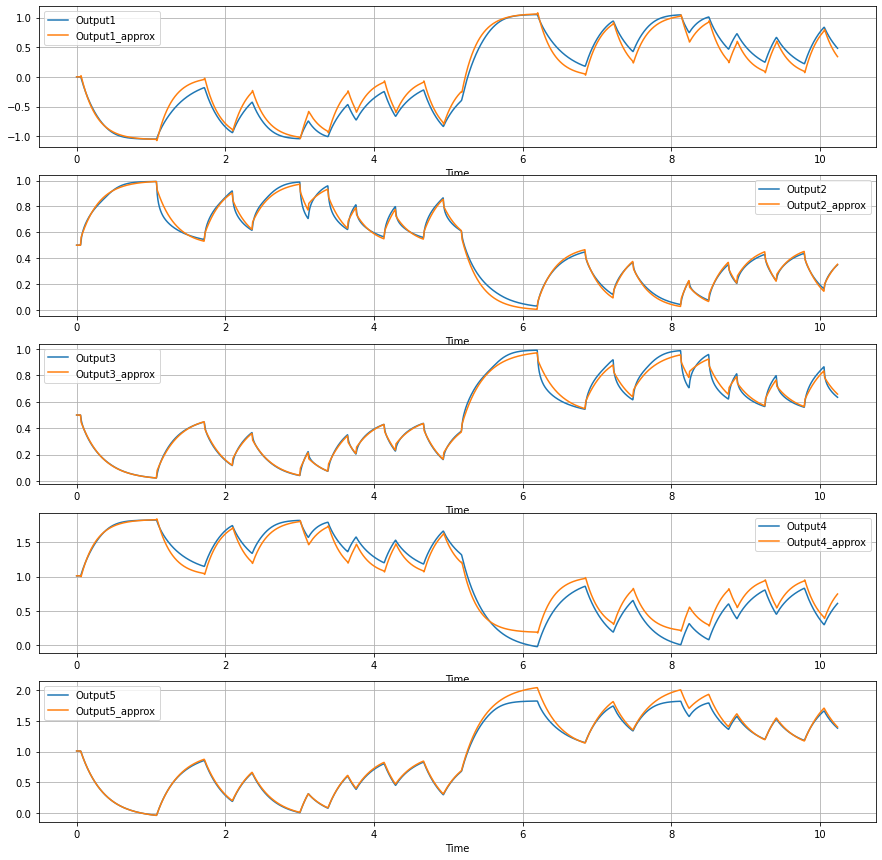

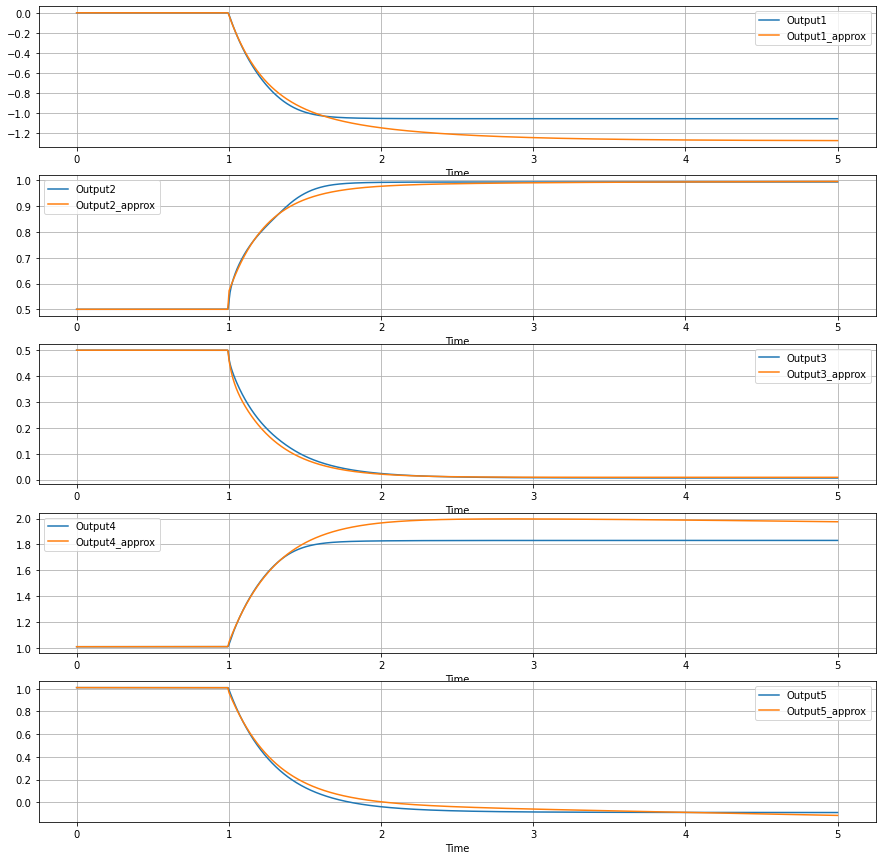

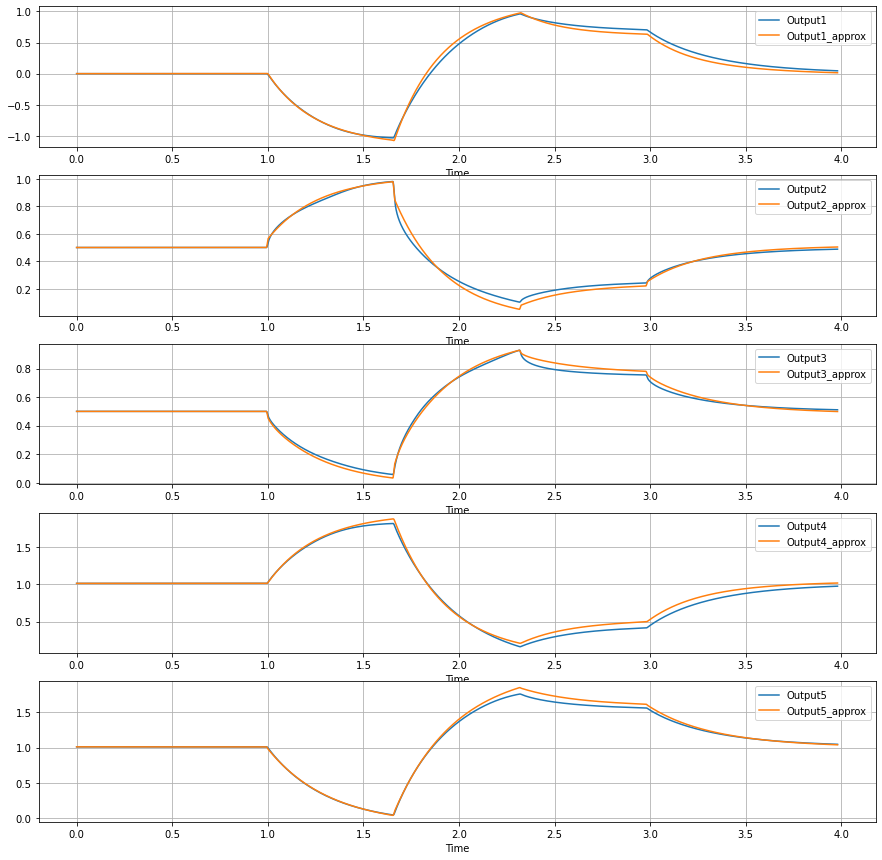

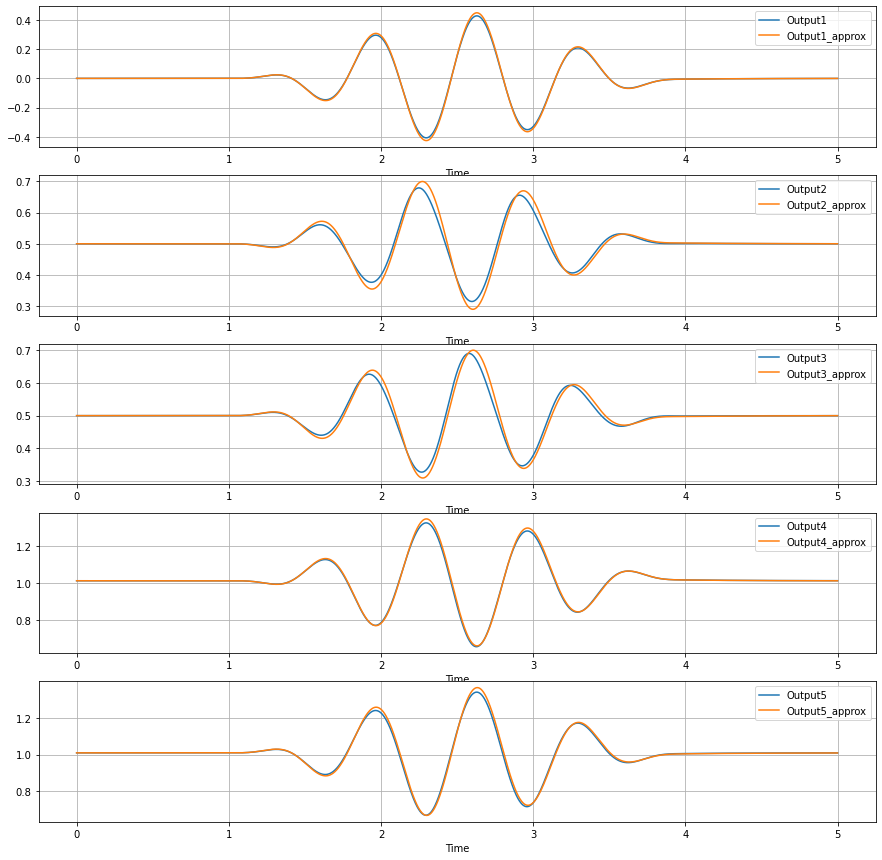

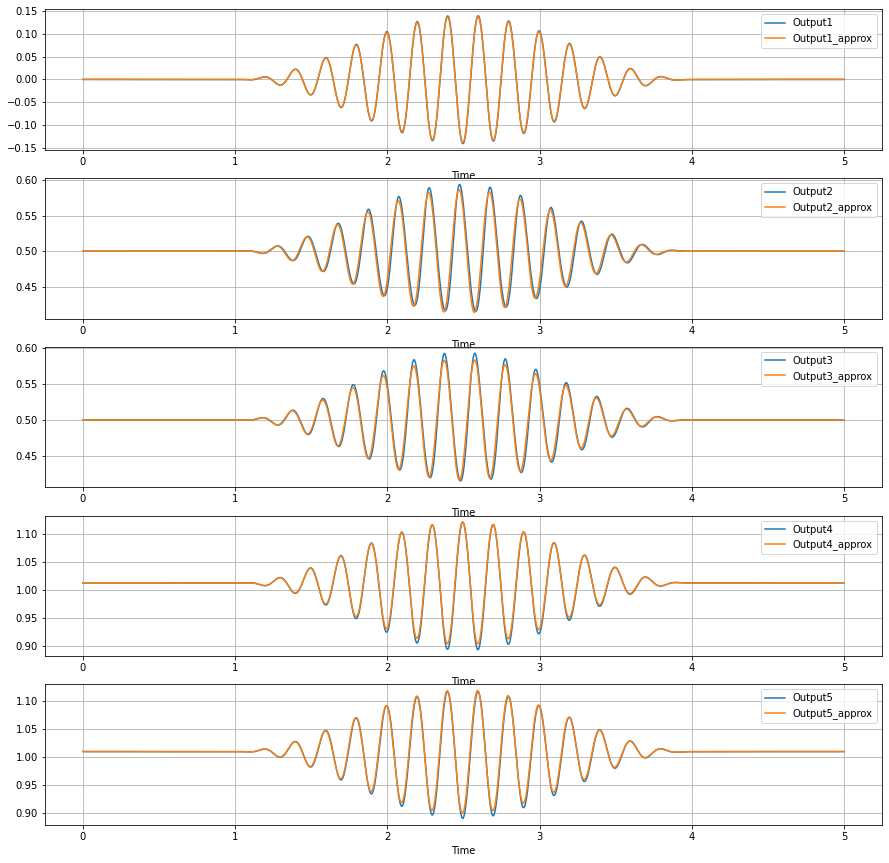

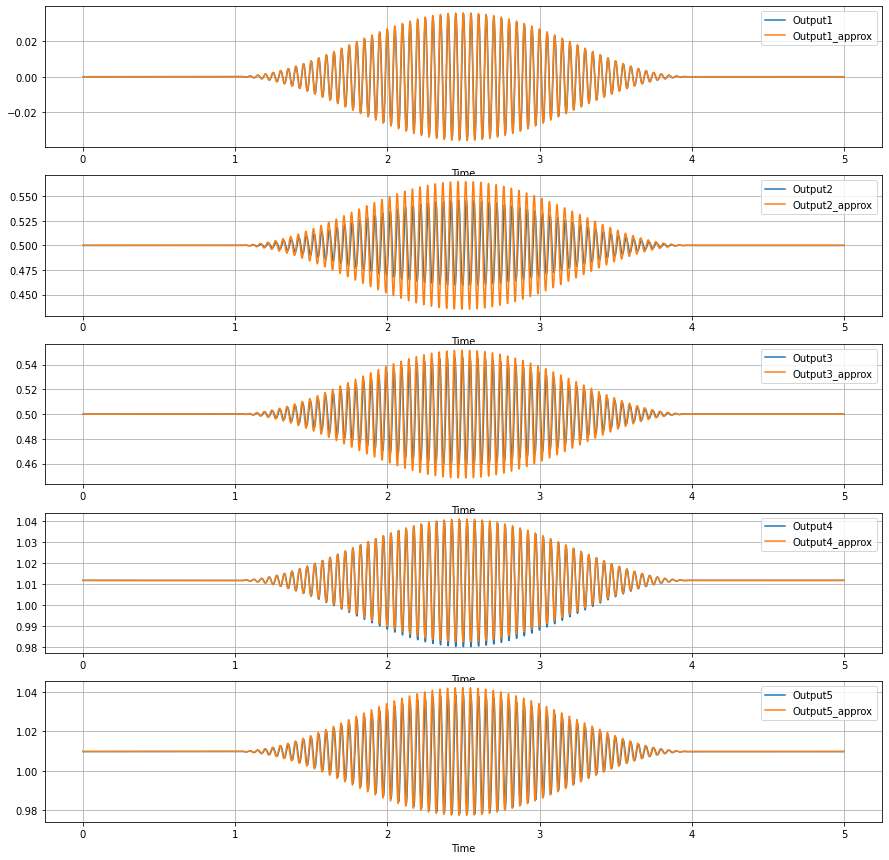

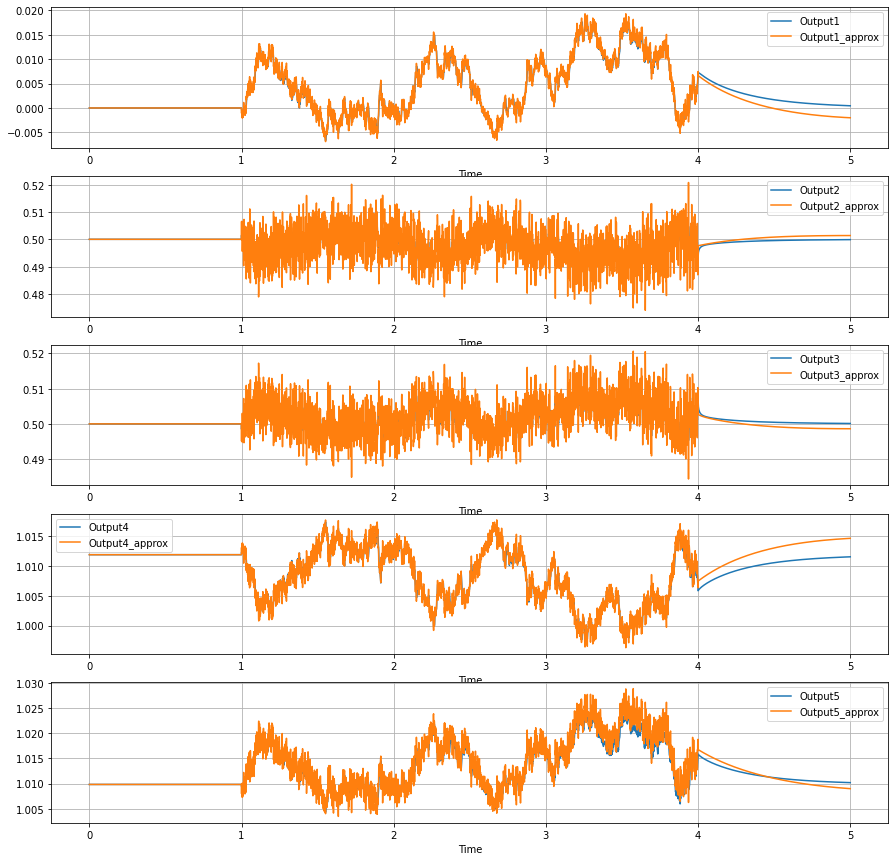

In [430]:
##Tracé des outputs et des outputs approximés sur l'échantillon de test

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in inputs:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v3[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

In [429]:
###RMSE pour les signaux de test

N_input   = 1
N_outputs = 5
N_signals = len(names)
mean_rmse = 0
inputs = ['input0','input1','input2','input3','input4','input5','input6']

for name in inputs:
    for k in range(N_outputs):
        rmse = RMSE(Sorties_v3[name][Output_names[k]],Sorties_v3[name][Output_names[k]+"_approx"])
        mean_rmse += rmse*(name in inputs)/(5*len(inputs))
        print("RMSE pour " + str(name) +" et " + Output_names[k] + " : " + str(rmse))
        print("-----------------")

print("RMSE moyenne sur echantillon sauf input0 : " + str(mean_rmse) )

RMSE pour input0 et Output1 : 0.014285358771271215
-----------------
RMSE pour input0 et Output2 : 0.0005488328140425355
-----------------
RMSE pour input0 et Output3 : 0.0006166005375687959
-----------------
RMSE pour input0 et Output4 : 0.0159563603356672
-----------------
RMSE pour input0 et Output5 : 0.003992236913282552
-----------------
RMSE pour input1 et Output1 : 0.022573550885293083
-----------------
RMSE pour input1 et Output2 : 7.982492426667803e-05
-----------------
RMSE pour input1 et Output3 : 5.029957576814306e-05
-----------------
RMSE pour input1 et Output4 : 0.015918408233181205
-----------------
RMSE pour input1 et Output5 : 0.0006077426588725892
-----------------
RMSE pour input2 et Output1 : 0.0021119354299635102
-----------------
RMSE pour input2 et Output2 : 0.0005495256294161348
-----------------
RMSE pour input2 et Output3 : 0.00040064710878291867
-----------------
RMSE pour input2 et Output4 : 0.0021198458209958355
-----------------
RMSE pour input2 et Output